In [1]:
import os

from datasets.loader import load_dataset
from models.XGB.forecast import *

import xgboost as xgb

## Define Parameters

In [4]:
ROOT_PATH = os.path.pardir

N_STEPS_IN_AR = 100
N_STEPS_OUT_AR = 30
N_STEPS_IN_WINDOW = 100
N_STEPS_OUT_WINDOW = 30

SUNSPOTS_PATH = os.path.join(ROOT_PATH, "datasets/Sunspots.csv")

## Load Dataset

### Dataset for window forecasting

In [6]:
ds_sunspots_window = load_dataset(
    raw_dataset=pd.read_csv(SUNSPOTS_PATH),
    n_steps_in=N_STEPS_IN_WINDOW,
    n_steps_out=N_STEPS_OUT_WINDOW,
    test_fraction=0.1
)

### Dataset for forecasting with autoregression

In [10]:
ds_sunspots_ar = load_dataset(
    raw_dataset=pd.read_csv(SUNSPOTS_PATH),
    n_steps_in=N_STEPS_IN_AR,
    n_steps_out=N_STEPS_OUT_AR,
    test_fraction=0.1
)

## Train XGBoost regressor

### Regressor for window regression

In [9]:
xgb_window = xgb.XGBRegressor()
xgb_window.fit(ds_sunspots_window.train_x, ds_sunspots_window.train_y)

xgb_window.save_model(
    os.path.join(ROOT_PATH, f"models/XGB/saved/window_forecast_{N_STEPS_IN_WINDOW}-{N_STEPS_OUT_WINDOW}.json")
)

### Regressor for autoregression

In [11]:
xgb_ar = xgb.XGBRegressor()
xgb_ar.fit(ds_sunspots_ar.train_x, ds_sunspots_ar.train_y)

xgb_ar.save_model(
    os.path.join(ROOT_PATH, f"models/XGB/saved/ar_forecast_{N_STEPS_IN_AR}-{N_STEPS_OUT_AR}.json")
)

## Forecast and evaluation

### Windowed

In [12]:
forecast = window_forecast(ds_sunspots_window.test_x, xgb_window)
forecast_series = get_forecast_series(forecast, ds_sunspots_window.n_train(), N_STEPS_IN_WINDOW, N_STEPS_OUT_WINDOW)

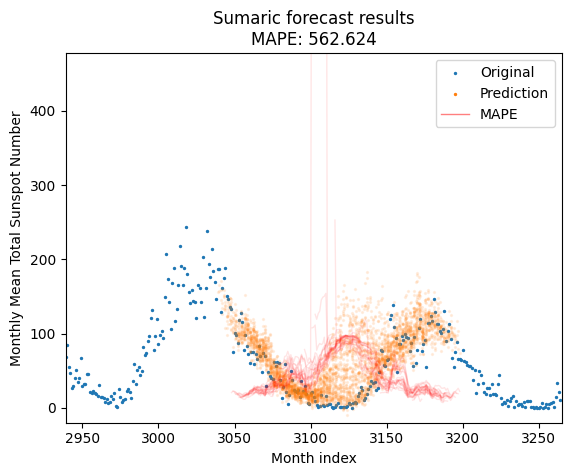

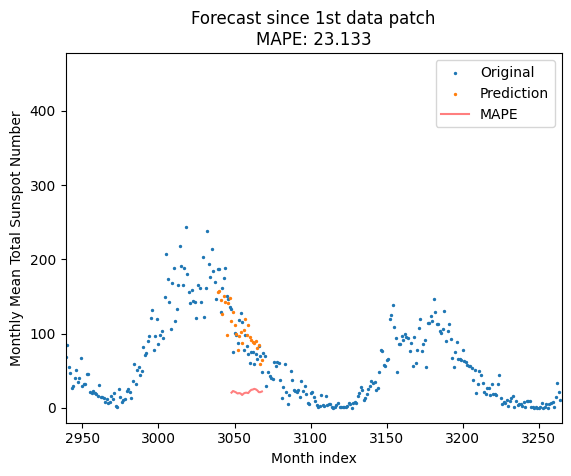

In [13]:
months_lim = (ds_sunspots_window.n_train(), ds_sunspots_window.n_values())
plot_forecasts(ds_sunspots_window.series_all, forecast_series, xlim=months_lim, metric_name="mape")
plot_forecast(ds_sunspots_window.series_all, forecast_series, 0, xlim=months_lim, metric_name="mape")

### Autoregression

In [14]:
forecast_ar = ar_forecast(ds_sunspots_ar.train_x, xgb_ar, ds_sunspots_ar.n_test(), N_STEPS_OUT_AR)
forecast_series_ar = get_forecast_series_ar(forecast_ar, ds_sunspots_ar.n_train(), N_STEPS_OUT_AR)

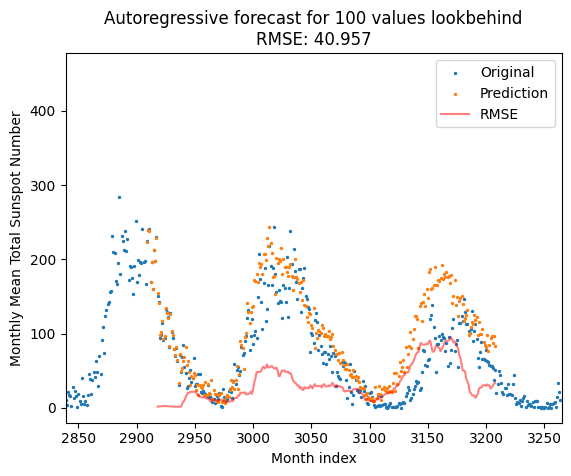

In [15]:
months_lim = (ds_sunspots_ar.n_train() - 100, ds_sunspots_ar.n_values())
plot_forecast_ar(ds_sunspots_ar.series_all, forecast_series_ar, months_lim, N_STEPS_IN_AR, metric_name="rmse")

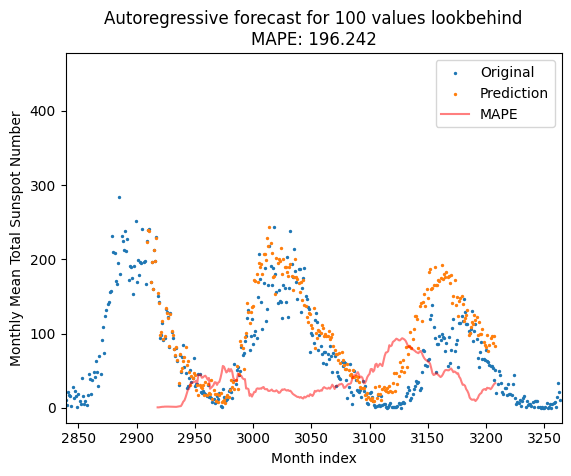

In [16]:
plot_forecast_ar(ds_sunspots_ar.series_all, forecast_series_ar, months_lim, N_STEPS_IN_AR, metric_name="mape")